In [1]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.datasets as datasets
from torch.autograd import Variable
from torch.utils.data import DataLoader

from torchvision import datasets, transforms
from torchvision.utils import save_image

c:\Anaconda\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Anaconda\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# Data handling
TRAIN_DIR = './data_map_cutouts/train4' #'../data__map_cutouts/train_v3'
BATCH_SIZE = 128


In [3]:
to_tensor = transforms.ToTensor()
random_flips_v = transforms.RandomVerticalFlip(0.5)
random_flips_h = transforms.RandomHorizontalFlip(0.5)
to_grayscale = transforms.Grayscale(1)

transform = transforms.Compose([
    to_grayscale,
    to_tensor,
    random_flips_h,
    random_flips_v
])

train_dir = pathlib.Path(TRAIN_DIR)  
train_data = datasets.ImageFolder(root      = train_dir, 
                                  transform = transform)
train_dataLoader = DataLoader(dataset = train_data,
                     batch_size = BATCH_SIZE, 
                     shuffle    = True,
                     drop_last  = True)


In [4]:
CIFAR_dataset = datasets.CIFAR10(root='./data/', train=True, 
                                      transform=transforms.Compose([to_grayscale, to_tensor]),
                                      download=True)
CIFAR_dataLoader = DataLoader(CIFAR_dataset, batch_size=BATCH_SIZE, shuffle=True)

Files already downloaded and verified


torch.Size([128, 1, 32, 32])


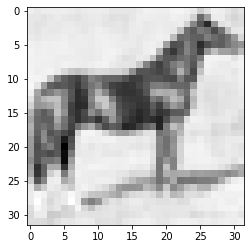

In [7]:
images, labels = next(iter(CIFAR_dataLoader))
print(images.shape)
plt.imshow(images[0, 0, :, :].detach().cpu().numpy(), cmap='Greys_r')

## Model

In [10]:
class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape
        # print(shape)

    def forward(self, x):
        return x.view(x.shape[0], *self.shape)
    
class VAE(nn.Module):
    def __init__(self, latent_dim) -> None:
        super().__init__()
        self.latent_dim = latent_dim
        self.cuda = torch.cuda.is_available
        self.device = torch.device("cuda" if self.cuda else "cpu")
        self.encoder = nn.Sequential(
            nn.Conv2d(
                in_channels   = 1,
                out_channels  = 32,
                kernel_size   = 3,
                stride        = 2,
                padding       = 1
            ),
            nn.BatchNorm2d(num_features = 32,
                           eps          = 0.01),
            nn.ReLU(
                # negative_slope=0.2,
                inplace=True),

            nn.Conv2d(
                in_channels   = 32,
                out_channels  = 64,
                kernel_size   = 3,
                stride        = 2,
                padding       = 1
            ),
            nn.BatchNorm2d(num_features = 64,
                           eps          = 0.01),
            nn.ReLU(
                # negative_slope=0.2,
                inplace=True),

            nn.Flatten(),
            nn.Linear(in_features  = 64*8**2, 
                      out_features = latent_dim*2),
            nn.Sigmoid()
        ).to(self.device)

        self.decoder = nn.Sequential(
            nn.Linear(in_features  = latent_dim, 
                      out_features = 32 * 8**2),
            Reshape((32, 8, 8)),
            nn.ConvTranspose2d(in_channels  = 32,
                      out_channels = 32,
                      kernel_size  = 3,
                      stride       = 2,
                      padding      = 1,
                      output_padding = 1
                      ),
            nn.BatchNorm2d(num_features= 32,
                           eps = 0.01),
            nn.ReLU(
                # negative_slope = 0.2,
                inplace        = True
            ),
            nn.ConvTranspose2d(in_channels  = 32,
                      out_channels = 16,
                      kernel_size  = 3,
                      stride       = 2,
                      padding      = 1,
                      output_padding = 1
                      ),
            nn.BatchNorm2d(num_features = 16,
                           eps = 0.01),
            nn.ReLU(
                # negative_slope = 0.2,
                inplace        = True
            ),            
            
            nn.ConvTranspose2d(in_channels  = 16,
                      out_channels = 8,
                      kernel_size  = 3,
                      stride       = 1,
                      padding      = 1,
                      output_padding = 0
                      ),
            nn.BatchNorm2d(num_features= 8,
                           eps = 0.01),
            
            nn.ReLU(
                # negative_slope = 0.2,
                inplace        = True
            ),            
            
            nn.ConvTranspose2d(in_channels  = 8,
                      out_channels = 4,
                      kernel_size  = 3,
                      stride       = 1,
                      padding      = 1,
                      output_padding = 0
                      ),
            nn.BatchNorm2d(num_features= 4,
                           eps = 0.01),
            
            nn.ReLU(
                # negative_slope = 0.2,
                inplace        = True
            ),         
            nn.ConvTranspose2d(in_channels  = 4,
                      out_channels = 1,
                      kernel_size  = 3,
                      stride       = 1,
                      padding      = 1,
                      output_padding = 0
                      ),
            nn.BatchNorm2d(num_features= 1,
                           eps = 0.01),
        ).to(self.device)
    
    def encode(self, x):
        mean = self.encoder(x)[:, :self.latent_dim]
        logvar = self.encoder(x)[:, self.latent_dim:]

        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        # eps ~ N(0,1)
        eps = torch.normal(mean = 0, std=1, size=mean.shape, device="cuda" if self.cuda else "cpu")
        # returning ~ N(mean, exp^(logvar/2))
        return eps * torch.exp(logvar * .5) + mean
    
    def decode(self, z, apply_sigmoid = False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = nn.Sigmoid()(logits).to(self.device)
            return probs
        return logits
    
    def sample(self, z=None):
        if z is None:
            z = torch.normal(mean = 0., std = 1., size=(BATCH_SIZE, self.latent_dim)).to(self.device)
        return self.decode(z, apply_sigmoid=False)
    
    def log_normal_pdf(self, sample, mean, logvar, raxis=1):
        # print("Logvar:", type(logvar))
        if type(logvar) == float and logvar == 0.:
            logvar = torch.FloatTensor([0.]).to(self.device)
        log2pi = np.log(2 * np.pi)
        return torch.sum(
            -0.5 * ((sample - mean)**2. * torch.exp(-logvar) + logvar + log2pi),
            dim=raxis)
    
    def compute_loss(self, x):
        mean, logvar = self.encode(x)
        
        z = self.reparameterize(mean, logvar)
        x_logit = self.decode(z)

        cross_ent = nn.functional.binary_cross_entropy_with_logits(x_logit, x, reduction='none')
        logpx_z = -torch.sum(cross_ent, dim=[1, 2, 3])
        logpz = self.log_normal_pdf(z, 0., 0.)
        logqz_x = self.log_normal_pdf(z, mean, logvar)
        return -torch.mean(logpx_z + logpz - logqz_x)
    
    def train_step(self, x, e_optim, d_optim):
        e_optim.zero_grad()
        d_optim.zero_grad()
        loss = self.compute_loss(x)
        loss.backward()
        e_optim.step()
        d_optim.step()
        return loss
    
    def train(self, dataLoader,
              n_epochs = 100, sample_interval = 100,
              save_interval = 5,
              lr = 0.001, betas=(0.5, 0.9),
              dumping_interval = 1000):
        
        losses = []
        e_optim = torch.optim.Adam(self.encoder.parameters(), lr=lr, betas=betas)
        d_optim = torch.optim.Adam(self.decoder.parameters(), lr=lr, betas=betas)
        for epoch in range(n_epochs):
            for idx, sample in enumerate(dataLoader):
                imgs = sample[0]
                real_imgs = imgs.to(self.device)
                losses.append(self.train_step(real_imgs, e_optim, d_optim).item())
                print(f'\r[Epoch {epoch+1}/{n_epochs}] [Batch {(idx+1) % len(dataLoader)}/{len(dataLoader)}] [Loss: {losses[-1]:.3f}]\t', end='')
        plt.plot(losses)

model = VAE(100)

In [11]:
z = np.random.normal(0, 1, (10, 1, 32, 32))
z = torch.cuda.FloatTensor(z)
gen_enc = model.encoder(z)
print(gen_enc.shape)

gen_loss = model.compute_loss(z)
gen_loss

torch.Size([10, 200])


tensor(839.9201, device='cuda:0', grad_fn=<NegBackward0>)

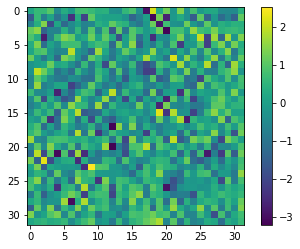

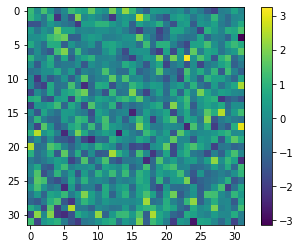

In [12]:
gen_img = model.decoder(gen_enc[:, :model.latent_dim]).detach().cpu().numpy()
gen_img.shape

plt.imshow(gen_img[0, 0, :, :])
plt.colorbar()
plt.show()
plt.imshow(z[0, 0, :, :].detach().cpu().numpy())
plt.colorbar()
plt.show()

[Epoch 10/10] [Batch 0/391] [Loss: 723.586]	]	

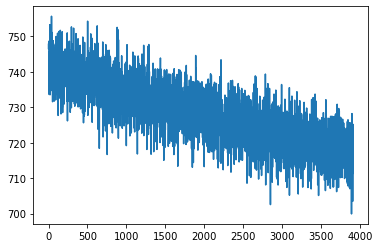

In [31]:
model.train(n_epochs=10, dataLoader=CIFAR_dataLoader, lr=1e-6)

In [15]:
import cv2
def sharpen_image(image, strength):
    # Create a sharpening kernel
    kernel = np.array([[-strength, -strength, -strength],
                       [-strength, 1 + 8 * strength, -strength],
                       [-strength, -strength, -strength]])
    
    # Apply the sharpening kernel to the image
    sharpened_image = cv2.filter2D(image, -1, kernel)
    
    return sharpened_image

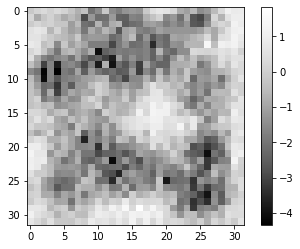

In [39]:
z = torch.normal(mean = 0., std=1.0, size=(BATCH_SIZE, model.latent_dim)).to(model.device)
gen_img = model.decode(z, apply_sigmoid=False)[0, 0, :, :].detach().cpu().numpy()

# gen_img = sharpen_image(gen_img, 0.03)

plt.imshow(((gen_img)), cmap='Greys_r')
plt.colorbar()
plt.show()
# print(gen_img)

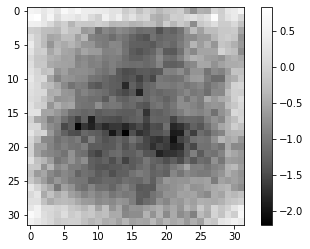

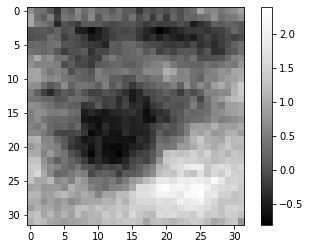

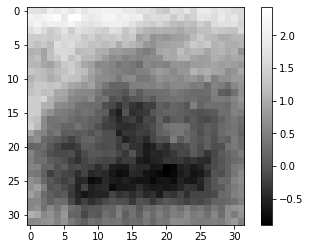

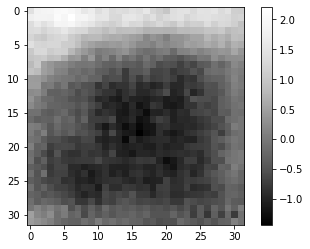

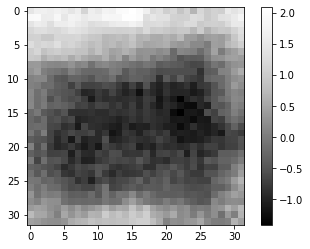

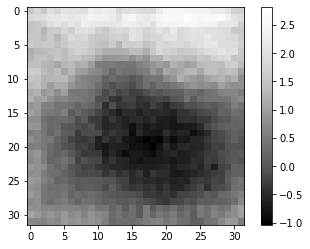

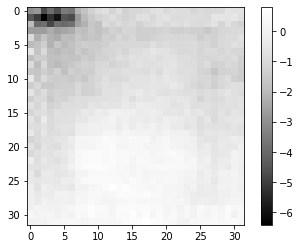

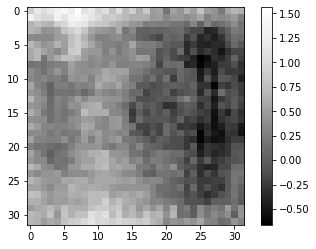

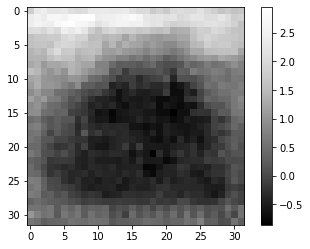

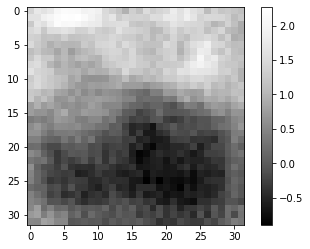

In [342]:
gen_imgs = model.decode(z, apply_sigmoid=False)[:, 0, :, :].detach().cpu().numpy()

for i in range(10):
    plt.imshow(gen_imgs[i+50, :, :], cmap='Greys_r')
    plt.colorbar()
    plt.show()

In [335]:
z[0, :]

tensor([ 0.4904, -1.0777,  0.9217, -0.4553, -0.9363,  1.0928,  0.5874, -0.4867,
         0.0298,  0.7703, -0.7358,  0.3231,  0.7188,  1.3974, -0.5908, -0.2779,
         1.0335,  2.0188,  0.0651, -1.1392,  0.4154,  2.5312, -0.8759, -0.7825,
         0.7119,  0.4820,  0.8148, -0.8036, -0.3317, -0.8036], device='cuda:0')

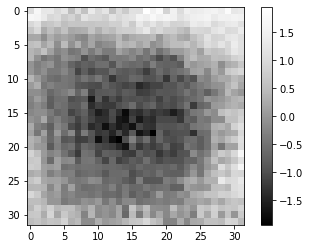

In [332]:
gen_img = sharpen_image(gen_img, 0.01)
plt.imshow(((gen_img)), cmap='Greys_r')
plt.colorbar()
plt.show()

(32, 32)


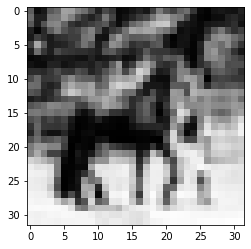

In [344]:
images, labels = next(iter(CIFAR_dataLoader))
images = images[0, 0, :, :].detach().cpu().numpy()
# images = sharpen_image(images, 0.03)
print(images.shape)
plt.imshow(images, cmap='Greys_r')

(32, 32)


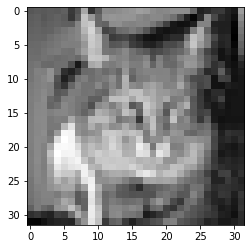

In [319]:
images = sharpen_image(images, 0.03)
print(images.shape)
plt.imshow(images, cmap='Greys_r')

In [ ]:
gen_imgs_2 = model.sample()[0, 0, :, :].detach().cpu().numpy()
plt.imshow((gen_imgs_2), cmap='Greys_r')
plt.colorbar()
plt.show()

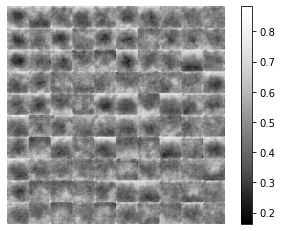

In [244]:
def plot_latent_images(model, n=5, epoch=10, im_size=128+2, save=False):
    img_w = im_size * n
    img_h = im_size * n

    image = np.zeros((img_h, img_w))

    norm = torch.distributions.Normal(0, 1)
    grid_x = norm.icdf(torch.linspace(0.05, 0.95, n))
    grid_y = norm.icdf(torch.linspace(0.05, 0.95, n))

    # print(grid_x.shape)

    for i, y_i in enumerate(grid_x):
        for j, x_j in enumerate(grid_y):
            z = torch.tensor([[x_j, y_i]])
            z = torch.cat([z, torch.normal(0., 1., size=(1, (model.latent_dim-2)))], dim=1).to(device=model.device)
            # print(z.shape)
            x_decoded = model.decode(z=z, apply_sigmoid=True)

            digit = x_decoded[0].view(im_size, im_size).detach().cpu().numpy()
            # digit = np.pad(digit, ((1,1), (1,1)), mode='constant', constant_values=0)
            # plt.imshow(digit)
            # plt.show()

            # digit = digit - np.min(digit)
            # digit = digit / np.max(digit)

            # print(np.max(digit), np.min(digit))

            image[i * im_size:(i+1)*im_size, j*im_size:(j+1)*im_size] = digit

    plt.imshow((image), cmap='Greys_r')
    plt.axis('off')
    plt.colorbar()
    plt.show()
plot_latent_images(model, n=10, im_size=32)

In [34]:
plot_latent_images(model, n=10)

RuntimeError: shape '[130, 130]' is invalid for input of size 1024

In [ ]:
z = torch.ones((1, model.latent_dim)).to(device=model.device)
z[:, 0:5] = 0. 
print(z)
img = model.decode(z)[0, 0, :, :].detach().cpu().numpy()
plt.imshow(img, cmap='Greys_r')
plt.colorbar()
plt.show()

In [ ]:
np.std(a)**2